In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import seaborn as sns

In [2]:
x_scale = 5
y_scale = 3

full_court_img = Image.open('../../data/wnba/ml-bg-court.png').resize((x_scale * 100, y_scale * 100), Image.ANTIALIAS)
full_court_img.size

(500, 300)

In [3]:
df_boxscores = pd.read_csv('../../data/wnba/wnba_boxscores.csv')
df_boxscores.head()

,side,team_name,player_name,id,nid,game_id,MIN,FG,3PT,FT,OREB,DREB,REB,AST,STL,BLK,TO,PF,+/-,PTS
0,away,Los Angeles Sparks,N. Ogwumike F,1068,nneka-ogwumike,401391651,37,7-10,2-3,3-3,2,5,7,2,3,0,3,2,+7,19
1,away,Los Angeles Sparks,A. Atwell F,4068885,amy-atwell,401391651,8,0-2,0-2,0-0,0,0,0,0,0,0,0,1,-7,0
2,away,Los Angeles Sparks,L. Cambage C,1017,liz-cambage,401391651,24,4-12,0-1,4-6,1,3,4,0,4,2,5,3,-3,12
3,away,Los Angeles Sparks,B. Sykes G,2988756,brittney-sykes,401391651,36,3-8,0-2,3-4,0,6,6,4,4,2,2,4,+3,9
4,away,Los Angeles Sparks,J. Canada G,3142250,jordin-canada,401391651,33,6-11,0-1,9-9,0,4,4,8,2,0,3,2,+3,21


In [4]:
df = pd.read_csv('../../data/wnba/wnba_shot_chart.csv')
df.head()

,game_id,description,location,made
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"['bottom:calc(32% - 5px);', 'left:calc(78.72% ...",False
1,401391651,Dana Evans misses driving floating jump shot,"['bottom:calc(42% - 5px);', 'left:calc(87.23% ...",False
2,401391651,Azura Stevens makes 23-foot three point jumper...,"['bottom:calc(6% - 5px);', 'left:calc(91.49% -...",True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"['bottom:calc(26% - 5px);', 'left:calc(88.3% -...",True
4,401391651,Candace Parker makes free throw 1 of 2,"['bottom:calc(429496780% - 5px);', 'left:calc(...",True


In [5]:
def who_shot(row):
    match = re.search(r'^([a-z\']+[\s-]+)+(?=makes|misses)', row, flags=re.IGNORECASE)
    if match is not None:
        return match.group().strip()
        
    match = re.search(r'blocks\s+([a-z\']+[\s-]+)+?(?=\'s)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return re.sub(r'^blocks\s+', '', match.group()).strip()

def who_blocked(row):
    match = re.search(r'^([a-z\']+[\s-]+)+(?=blocks)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group().strip()

def distance(row):
    match = re.search(r'(\d+)[\s-]+foot', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

def shot(row):
    match = re.search(r'(pullup|floating|step\s+back)\s+jump', row)
    if match is None:
        match = re.search(r'(layup)', row)

    if match is None:
        match = re.search(r'(hook|jumper)', row)

    if match is None:
        match = re.search(r'(free\s+throw)', row)

    if match is None:
        return 'set'

    return match.group(1).strip()

def assist(row):
    match = re.search(r'\(((?:[a-z\']+[\s-])+)(?=assists)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

def is_3pt(row):
    shot_distance = row['shot_distance']
    if len(shot_distance) > 0:
        return int(shot_distance) >= 22
    
    return len(re.findall(r'three\s+point', row['description'])) > 0

df['shot_by'] = df.description.map(who_shot)
df['shot_distance'] = df.description.map(distance)
df['blocked_by'] = df.description.map(who_blocked)
df['shot_type'] = df.description.map(shot)
df['assist_by'] = df.description.map(assist)

df['is_3pt'] = df.apply(is_3pt, axis=1)

In [6]:
def parse(loc):
  locations = list(map(float, re.findall(r'calc\(([\d.]+)%', ' '.join(loc))))
  if len(locations) != 2:
    return [-1, -1]

  ## css is bottom ... bottom 6% would mean lower shot near line
  ##                   bottom 96% would mean upper shot new line
  return [ round(x, 2) for x in locations ]

def is_valid(loc):
  return not any(list(map(lambda a: a > 100 or a < 0, loc)))

df.location = df.location.map(eval).map(parse)
df['is_valid'] = df.location.map(is_valid)

df.head(n=10)

,game_id,description,location,made,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_3pt,is_valid
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,Courtney Vandersloot,18,,pullup,,False,True
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,Dana Evans,,,floating,,False,True
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,Azura Stevens,23,,jumper,Candace Parker,True,True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,Candace Parker,14,,set,Azura Stevens,False,True
4,401391651,Candace Parker makes free throw 1 of 2,"[429496780.0, 228455803.19]",True,Candace Parker,,,free throw,,False,False
5,401391651,Candace Parker makes free throw 2 of 2,"[429496780.0, 228455803.19]",True,Candace Parker,,,free throw,,False,False
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,Candace Parker,25,,jumper,Courtney Vandersloot,True,True
7,401391651,Azura Stevens makes 2-foot layup (Candace Park...,"[48.0, 94.68]",True,Azura Stevens,2,,layup,Candace Parker,False,True
8,401391651,Azura Stevens misses two point shot,"[42.0, 95.74]",False,Azura Stevens,,,set,,False,True
9,401391651,Brittney Sykes blocks Kaela Davis 's 2-foot dr...,"[54.0, 93.62]",False,Kaela Davis,2,Brittney Sykes,layup,,False,True


In [7]:
## only use the valid shot locations moving forward
df_valid = df[df.is_valid].copy()

In [8]:
def side(loc):
  return 'right' if loc[1] >= 50  else 'left'

df_valid['side_of_court'] = df_valid.location.map(lambda loc: 'right' if loc[1] >= 50  else 'left')

def flip(row):

  location = row['location']
  shot_distance = row['shot_distance']

  if shot_distance != '' and int(shot_distance) >= 46:
    return [50, 50]

  if row['side_of_court'] == 'right':
    x = location[1]
    y = location[0]  

    return [round(100-y, 1), round(100-x, 1)]

  return location

df_valid['single_location'] = df_valid.apply(flip, axis=1)
df_valid['side_of_the_half_court'] = df_valid.single_location.map(lambda loc: 'right' if loc[0] > 50 else 'left') ## doesnt make sense yet...

df_valid.head(n=5)

,game_id,description,location,made,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_3pt,is_valid,side_of_court,single_location,side_of_the_half_court
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,Courtney Vandersloot,18,,pullup,,False,True,right,"[68.0, 21.3]",right
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,Dana Evans,,,floating,,False,True,right,"[58.0, 12.8]",right
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,Azura Stevens,23,,jumper,Candace Parker,True,True,right,"[94.0, 8.5]",right
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,Candace Parker,14,,set,Azura Stevens,False,True,right,"[74.0, 11.7]",right
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,Candace Parker,25,,jumper,Courtney Vandersloot,True,True,right,"[76.0, 26.6]",right


In [9]:
player = 'Kelsey Plum' ## 'Sylvia Fowles'
df_player = df_valid[df_valid.shot_by == player]

df_player.head()

,game_id,description,location,made,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_3pt,is_valid,side_of_court,single_location,side_of_the_half_court
1119,401391696,Kelsey Plum makes driving layup,"[48.0, 5.32]",True,Kelsey Plum,,,layup,,False,True,left,"[48.0, 5.32]",left
1130,401391696,Kelsey Plum makes driving layup,"[48.0, 4.26]",True,Kelsey Plum,,,layup,,False,True,left,"[48.0, 4.26]",left
1132,401391696,Kelsey Plum makes 25-foot three pointer (Jacki...,"[40.0, 29.79]",True,Kelsey Plum,25,,set,Jackie Young,True,True,left,"[40.0, 29.79]",left
1134,401391696,Kelsey Plum makes 24-foot step back jumpshot (...,"[20.0, 24.47]",True,Kelsey Plum,24,,step back,Theresa Plaisance,True,True,left,"[20.0, 24.47]",left
1135,401391696,Kelsey Plum misses 24-foot step back jumpshot,"[70.0, 27.66]",False,Kelsey Plum,24,,step back,,True,True,left,"[70.0, 27.66]",right


## Full Shot Chart

In [10]:
def get_makes_and_misses_full_court(df):
    def get_coordinates(df):
        x = df.location.map(lambda a: a[1])
        y = df.location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


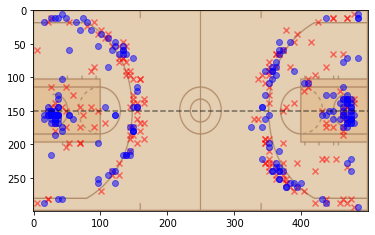

In [11]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_full_court(df_player)
ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

## y-axis flips, need to flip the y data...
ax.imshow(full_court_img)

plt.show()

## Half Shot Chart

In [12]:
def get_makes_and_misses_half_court(df):
    def get_coordinates(df):
        x = df.single_location.map(lambda a: a[1])
        y = df.single_location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


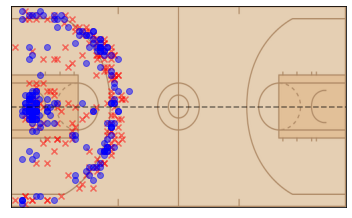

In [13]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_player)

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

## How well did we pick up 3pt?

Kelsey Plum - shot chart


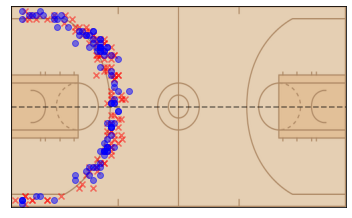

In [14]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_player[df_player.is_3pt])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

In [15]:
df_player[df_player.is_3pt].groupby(['made', 'side_of_the_half_court']).count()[['game_id']]

game_id
made  side_of_the_half_court         
False left                         50
      right                        75
True  left                         40
      right                        56

In [16]:
df_agg_makes = df[np.logical_and(np.logical_and(df.shot_by == player, df.is_3pt), df.made)].groupby(['game_id']).count()[['made']]
df_agg_misses = df[np.logical_and(np.logical_and(df.shot_by == player, df.is_3pt), ~df.made)].groupby(['game_id']).count()[['made']]
df_agg_misses.columns = ['misses']

df_totals = df_agg_makes.join(df_agg_misses)
def format_3pt(row):
    made = row['made']
    miss = row['misses']
    total = made + miss

    return f'{made}-{total}'

df_totals['3PT'] = df_totals.apply(format_3pt, axis=1)

In [17]:
validation = pd.merge(
    df_boxscores.loc[df_boxscores.id == 3065570, ['game_id', '3PT']],
    df_totals,
    how="left",
    on='game_id'
)[['game_id', '3PT_x', '3PT_y']]

validation['is_correct'] = validation['3PT_x'] == validation['3PT_y']

validation

,game_id,3PT_x,3PT_y,is_correct
0,401391696,2-4,2-4,True
1,401391747,3-8,3-8,True
2,401391652,5-9,5-9,True
3,401391657,2-5,2-6,False
4,401391659,3-7,3-7,True
5,401391665,3-4,3-4,True
6,401391675,4-8,4-8,True
7,401391678,1-8,1-8,True
8,401391683,3-6,3-6,True
9,401391687,5-8,5-8,True


### Takeaways:
  - 22-foot not exactly == 3pt

  - when no distance maybe look at location... create a simple ploy model to help with those?


### Can we impute 3pt from location?

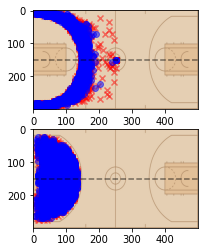

In [42]:
fig, ax = plt.subplots(2)

## def. 3pt
df_3pt = df_valid[
    np.logical_and(
        df_valid.shot_distance.map(lambda a: -1 if a == '' else int(a)) > 22, ## have distance, > 22
        df_valid.is_3pt,
    )
]

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_3pt)

ax[0].scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax[0].scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax[0].axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax[0].imshow(full_court_img)

## def. 2pt
df_2pt = df_valid[
    np.logical_and(
        df_valid.shot_distance.map(lambda a: 50 if a == '' else int(a)) < 22, ## have distance, > 22
        ~df_valid.is_3pt,
    )
]

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_2pt)

ax[1].scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax[1].scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax[1].axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax[1].imshow(full_court_img)

plt.show()

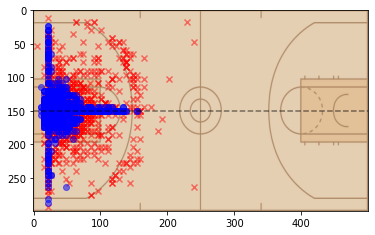

In [41]:
fig, ax = plt.subplots()

df_unlabeled = df_valid[
    np.logical_and(
        df_valid.shot_distance.str.len() == 0, ## have distance, > 22
        ~df_valid.is_3pt,
    )
].copy()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_unlabeled)

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax.imshow(full_court_img)

plt.show()

In [38]:
from sklearn.svm import SVC

df_training = pd.concat([
    df_3pt[['single_location', 'is_3pt']],
    df_2pt[['single_location', 'is_3pt']]
]).sample(frac=1)

X = df_training.single_location.tolist()
y = df_training.is_3pt.astype(int).tolist()

model = SVC(random_state=42)
model.fit(X, y)
model.score(X, y)

0.9992567358315267

In [33]:
df_unlabeled = df_valid[
    np.logical_and(
        df_valid.shot_distance.str.len() == 0, ## have distance, > 22
        ~df_valid.is_3pt,
    )
].copy()

df_unlabeled['predicted_3pt'] = model.predict(df_unlabeled.single_location.tolist())
df_unlabeled.is_3pt = df_unlabeled.predicted_3pt.astype(bool)

df_unlabeled.head()

,game_id,description,location,made,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_3pt,is_valid,side_of_court,single_location,side_of_the_half_court,predicted_3pt
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,Dana Evans,,,floating,,False,True,right,"[58.0, 12.8]",right,0
8,401391651,Azura Stevens misses two point shot,"[42.0, 95.74]",False,Azura Stevens,,,set,,False,True,right,"[58.0, 4.3]",right,0
15,401391651,Ruthy Hebard makes layup (Kaela Davis assists),"[48.0, 95.74]",True,Ruthy Hebard,,,layup,Kaela Davis,False,True,right,"[52.0, 4.3]",right,0
21,401391651,Courtney Vandersloot misses driving layup,"[52.0, 95.74]",False,Courtney Vandersloot,,,layup,,False,True,right,"[48.0, 4.3]",left,0
23,401391651,Azura Stevens makes layup (Candace Parker assi...,"[52.0, 94.68]",True,Azura Stevens,,,layup,Candace Parker,False,True,right,"[48.0, 5.3]",left,0


115


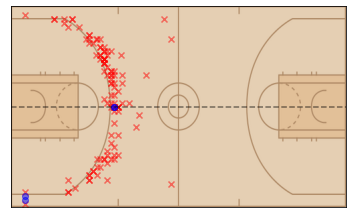

In [35]:
fig, ax = plt.subplots()

print(len(df_unlabeled[df_unlabeled.is_3pt]))

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(
    df_unlabeled[df_unlabeled.is_3pt]
)

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

### parsed data

In [22]:
## shot type
df.shot_type.unique()

array(['pullup', 'floating', 'jumper', 'set', 'free throw', 'layup',
       'step back', 'hook'], dtype=object)

In [23]:
## shots
sorted(df.shot_by.unique(), key=len, reverse=True)

['Ameshya Williams-Holliday',
 'Shatori Walker-Kimbrough',
 'Mikiah Herbert Harrigan',
 'Courtney Vandersloot',
 'Skylar Diggins-Smith',
 'Imani McGee-Stafford',
 'Crystal Dangerfield',
 'Beatrice Mompremier',
 'Katie Lou Samuelson',
 'Olivia Nelson-Ododa',
 'Jocelyn Willoughby',
 'Michaela Onyenwere',
 'Elizabeth Williams',
 'Myisha Hines-Allen',
 'Destanni Henderson',
 'DiJonai Carrington',
 'Elena Delle Donne',
 'Danielle Robinson',
 'Theresa Plaisance',
 'Diamond DeShields',
 'Sophie Cunningham',
 'Courtney Williams',
 'Isabelle Harrison',
 'Emmanuelle Tahane',
 'Layshia Clarendon',
 'Stephanie Mavunga',
 'Bridget Carleton',
 'Moriah Jefferson',
 'Epiphanny Prince',
 'Stephanie Talbot',
 'Victoria Vivians',
 'Tiffany Mitchell',
 'Monique Billings',
 'Natisha Hiedeman',
 'Arike Ogunbowale',
 'Kysre Gondrezick',
 'Mercedes Russell',
 'Arella Guirantes',
 'Angel McCoughtry',
 'Karlie Samuelson',
 'Chiney Ogwumike',
 'Chennedy Carter',
 'Rebekah Gardner',
 'Sabrina Ionescu',
 'Stefanie

In [24]:
## blocks
sorted(df.blocked_by.unique(), key=len, reverse=True)

['Shatori Walker-Kimbrough',
 'Mikiah Herbert Harrigan',
 'Courtney Vandersloot',
 'Skylar Diggins-Smith',
 'Beatrice Mompremier',
 'Olivia Nelson-Ododa',
 'Crystal Dangerfield',
 'Katie Lou Samuelson',
 'Michaela Onyenwere',
 'Jocelyn Willoughby',
 'Destanni Henderson',
 'Elizabeth Williams',
 'Myisha Hines-Allen',
 'DiJonai Carrington',
 'Elena Delle Donne',
 'Sophie Cunningham',
 'Diamond DeShields',
 'Isabelle Harrison',
 'Theresa Plaisance',
 'Courtney Williams',
 'Danielle Robinson',
 'Stephanie Mavunga',
 'Epiphanny Prince',
 'Moriah Jefferson',
 'Stephanie Talbot',
 'Tiffany Mitchell',
 'Natisha Hiedeman',
 'Monique Billings',
 'Bridget Carleton',
 'Angel McCoughtry',
 'Arike Ogunbowale',
 'Victoria Vivians',
 'Sabrina Ionescu',
 'Rebekah Gardner',
 'Megan Gustafson',
 'Stefanie Dolson',
 'Cheyenne Parker',
 'Kelsey Mitchell',
 'Jessica Shepard',
 'Chiney Ogwumike',
 'Veronica Burton',
 'Marine Johannes',
 'Unique Thompson',
 'Breanna Stewart',
 'Evina Westbrook',
 'Chennedy Ca

In [25]:
## assists
sorted(df.assist_by.unique(), key=len, reverse=True)

['Shatori Walker-Kimbrough',
 'Courtney Vandersloot',
 'Skylar Diggins-Smith',
 'Imani McGee-Stafford',
 'Crystal Dangerfield',
 'Katie Lou Samuelson',
 'Beatrice Mompremier',
 'Olivia Nelson-Ododa',
 'Destanni Henderson',
 'Myisha Hines-Allen',
 'DiJonai Carrington',
 'Michaela Onyenwere',
 'Jocelyn Willoughby',
 'Elizabeth Williams',
 'Elena Delle Donne',
 'Danielle Robinson',
 'Theresa Plaisance',
 'Sophie Cunningham',
 'Diamond DeShields',
 'Courtney Williams',
 'Isabelle Harrison',
 'Emmanuelle Tahane',
 'Layshia Clarendon',
 'Stephanie Mavunga',
 'Moriah Jefferson',
 'Bridget Carleton',
 'Stephanie Talbot',
 'Epiphanny Prince',
 'Tiffany Mitchell',
 'Victoria Vivians',
 'Natisha Hiedeman',
 'Monique Billings',
 'Arike Ogunbowale',
 'Kysre Gondrezick',
 'Mercedes Russell',
 'Arella Guirantes',
 'Angel McCoughtry',
 'Karlie Samuelson',
 'Rebekah Gardner',
 'Sabrina Ionescu',
 'Jessica Shepard',
 'Evina Westbrook',
 'Breanna Stewart',
 'Kelsey Mitchell',
 'Megan Gustafson',
 'Cheyen

In [26]:
## shot distances

## 91.86 ft ..., -1 == 'Not Given'
sorted(list(map(lambda a: -1 if a == '' else int(a), df.shot_distance.unique())))

[-1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 60,
 64,
 65,
 66,
 74,
 82]